# Project: Reconocimiento de Formas y Aprendizaje Automático

## Introduction
The goal of this project is to classify images from the **Oxford-IIIT Pet dataset**, a widely-used dataset containing images of 37 different breeds of cats and dogs. Each image is labeled with the corresponding breed, making this a multiclass classification problem.

This task presents several challenges:
- **Intra-class variability**: Images of the same breed may vary significantly in terms of lighting, pose, and background.
- **Inter-class similarity**: Some breeds, especially among cats, are visually similar, making the classification task more difficult.
- **Small dataset size**: The dataset consists of 7,349 images, with roughly 200 images per class.

### Project Objectives
In this project, the aim is to explore and implement various neural network architectures, starting from simple Multilayer Perceptrons (MLPs) and gradually moving towards Convolutional Neural Networks (CNNs). Additionally, techniques such as transfer learning and fine-tuning are applied to improve accuracy.

To address the challenges posed by the dataset, we will also apply **data augmentation** to increase the effective size of the training data and improve generalization.

The project will be structured as follows:
0. Data Exploration
1. Baseline model using a simple MLP.
2. Tuning the architecture to optimize the performance.
3. Hyperparameter adjustments to improve learning.
4. Implementation of CNNs
5. Transfer Learning
6. Fine-tuning of the pre-trained models for further improvement.
7. Data Augmentation to mitigate overfitting
8. Additional Model SOTA

For the data set, accuracy is the primary metric used to evaluate model performance. In addition, Top-5 accuracy is used to provide information on how often the correct class appears among the top five predictions. This is especially useful when some classes are difficult to distinguish, as it provides a broader perspective than strict accuracy.

During training, validation accuracy is monitored to assess how well the model generalizes to unseen data and to ensure that the model does not overfit the training set.

In more advanced stages, accuracy, recall and other per-class metrics will be evaluated to gain insight into the model's performance. This approach will help identify which specific classes are accurately predicted and which present more challenges, allowing for a more refined analysis of the model's effectiveness.

## 0.Data Exploration


In this section, an initial exploration of the data set is performed to understand its structure, distribution and possible imbalances. This step helps to understand the key characteristics of the data, which will inform the development of the model in later stages.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras; import tensorflow as tf; import tensorflow_datasets as tfds
from tensorflow.keras import layers
!pip install keras_tuner
import keras_tuner
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
keras.utils.set_random_seed(23)

(ds_train, ds_val, ds_test), info = tfds.load(
    'oxford_iiit_pet',
    split=['train', 'test[50%:]', 'test[:50%]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

total_images = info.splits['train'].num_examples + info.splits['test'].num_examples
num_classes = info.features['label'].num_classes
class_names = info.features['label'].names
image_shape = info.features['image'].shape

print(f"Total number of images: {total_images}")
print(f"Training images: {info.splits['train'].num_examples}")
print(f"Test images: {info.splits['test'].num_examples}")
print(f"Number of classes: {num_classes}")
print(f"Image dimensions: {image_shape}")
print(f"Class names: {class_names}")

Total number of images: 7349
Training images: 3680
Test images: 3669
Number of classes: 37
Image dimensions: (None, None, 3)
Class names: ['Abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'Bengal', 'Birman', 'Bombay', 'boxer', 'British_Shorthair', 'chihuahua', 'Egyptian_Mau', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'Maine_Coon', 'miniature_pinscher', 'newfoundland', 'Persian', 'pomeranian', 'pug', 'Ragdoll', 'Russian_Blue', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'Siamese', 'Sphynx', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


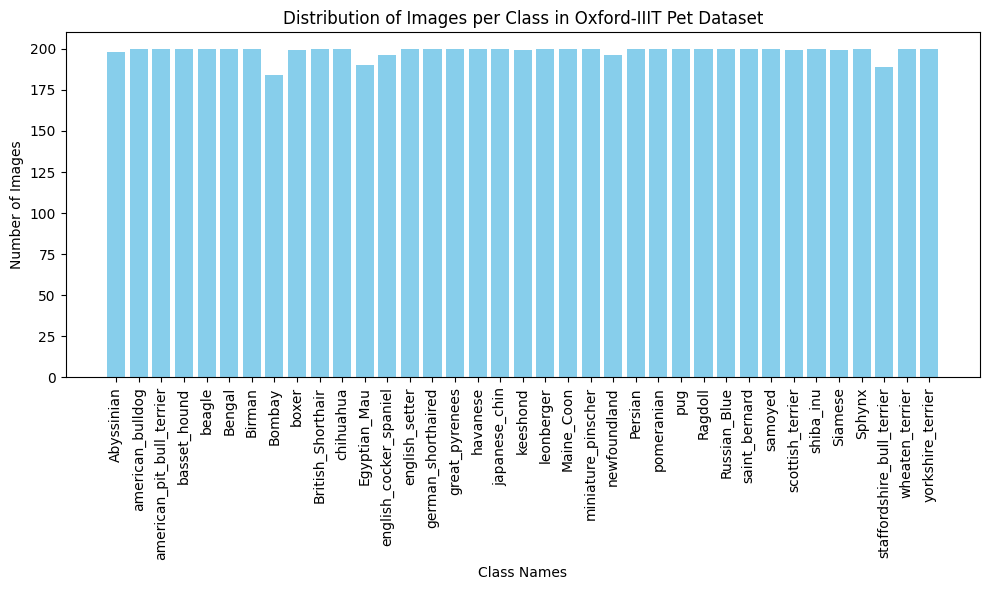

In [ ]:
num_classes = info.features['label'].num_classes
class_names = info.features['label'].names

train_labels = [label.numpy() for _, label in ds_train]
test_labels = [label.numpy() for _, label in ds_test]
val_labels = [label.numpy() for _, label in ds_val]
all_labels = np.concatenate([train_labels, test_labels, val_labels])
class_counts = np.bincount(all_labels, minlength=num_classes)

plt.figure(figsize=(10, 6))
plt.bar(class_names, class_counts, color='skyblue')
plt.xticks(rotation=90)
plt.title('Distribution of Images per Class in Oxford-IIIT Pet Dataset')
plt.ylabel('Number of Images')
plt.xlabel('Class Names')
plt.tight_layout()
plt.show()

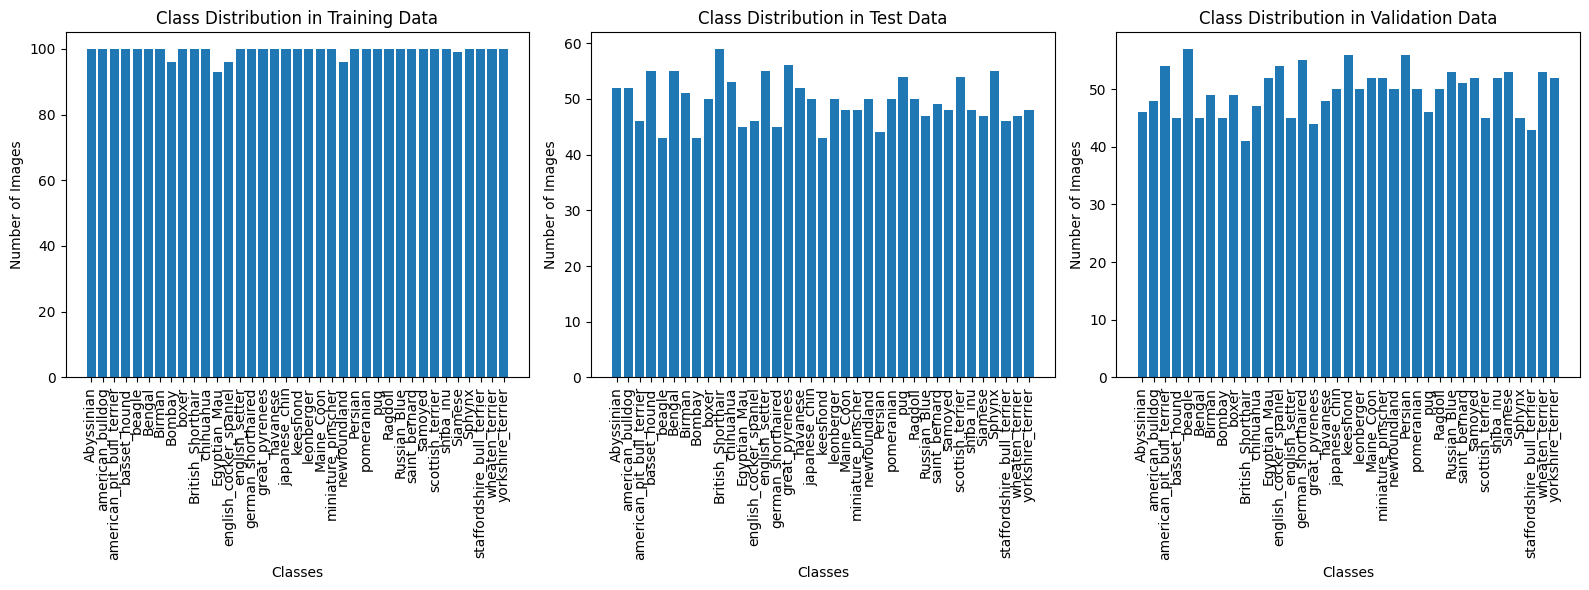

In [ ]:
def count_classes(dataset, num_classes):
    class_counts = np.zeros(num_classes, dtype=int)
    for image, label in dataset:
        class_counts[int(label)] += 1
    return class_counts

train_class_counts = count_classes(ds_train, num_classes)
test_class_counts = count_classes(ds_test, num_classes)
val_class_counts = count_classes(ds_val, num_classes)

fig, axes = plt.subplots(1, 3, figsize=(16, 6))
axes[0].bar(class_names, train_class_counts)
axes[0].set_title('Class Distribution in Training Data')
axes[0].set_xlabel('Classes')
axes[0].set_ylabel('Number of Images')
axes[0].tick_params(axis='x', rotation=90)
axes[1].bar(class_names, test_class_counts)
axes[1].set_title('Class Distribution in Test Data')
axes[1].set_xlabel('Classes')
axes[1].set_ylabel('Number of Images')
axes[1].tick_params(axis='x', rotation=90)
axes[2].bar(class_names, val_class_counts)
axes[2].set_title('Class Distribution in Validation Data')
axes[2].set_xlabel('Classes')
axes[2].set_ylabel('Number of Images')
axes[2].tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

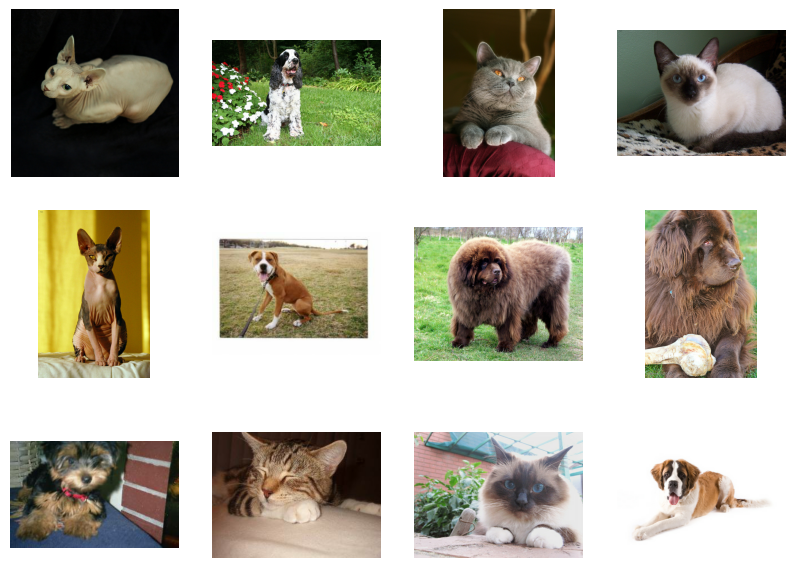

In [ ]:
fig = plt.figure(figsize=(10, 10))

for i, (image, label) in enumerate(ds_train.take(12)):
    fig.add_subplot(4, 4, i + 1)
    plt.imshow(image)
    plt.axis('off')
plt.show()

In [ ]:
IMG_SIZE = (64, 64)

def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0
    return image, label

As seen in the figures, there are no significant class imbalances in the full dataset, with approximately 200 images per class across 37 classes (breeds of cats and dogs). Additionally, due to shuffling, there are no major imbalances in the training, validation, or test datasets. In total, the dataset consists of 7,349 images, and the splits were made as 50% for training, 25% for validation, and 25% for testing.

As observed, the images in the dataset vary in size and scale, which necessitates preprocessing to ensure uniformity. To achieve this, all images are resized to a consistent target size. Additionally, pixel values are normalized to standardize the range of input data, improving model performance and stability during training. The model will be trained with batches of size 32.

In [ ]:
BATCH_SIZE = 32

ds_train = ds_train.map(preprocess).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

num_classes = info.features['label'].num_classes

## 1.Baseline model using a simple MLP.

The first model used for this project is a simple neural network architecture designed for image classification.
- **Input Layer**: Accepts images resized to 64x64 pixels with 3 color channels (RGB).
- **Flatten Layer**: Converts the 2D image data into a 1D vector
- **Dense Layer**: 800 units with ReLU activation
- **Output Layer**: 37 units (equal to the number of classes in the dataset), with a softmax activation function

The training process uses sparse categorical cross-entropy as the loss function, which is suitable when the labels are provided as integer values rather than one-hot encoded vectors. The batch size was 32. A learning rate of 0.0001 was chosen.


In [ ]:
class MyHyperModel(keras_tuner.HyperModel):
    def build(self, hp):
        M = keras.Sequential()
        M.add(keras.Input(shape=(64, 64, 3)))
        M.add(layers.Flatten())
        M.add(layers.Dense(units=800, activation='relu'))
        M.add(layers.Dense(num_classes, activation='softmax'))

        M.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            loss='sparse_categorical_crossentropy',
            metrics=[
                'accuracy',
                SparseTopKCategoricalAccuracy(k=5, name='top_5_accuracy')]
        )
        return M


In [ ]:
model = MyHyperModel().build(None)
history = model.fit(ds_train, validation_data=ds_val, epochs=20, batch_size=BATCH_SIZE, verbose=0)

In [ ]:
test_loss, test_accuracy, test_top5_accuracy = model.evaluate(ds_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Top-5 Accuracy: {test_top5_accuracy:.4f}")

58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.0878 - loss: 3.4746 - top_5_accuracy: 0.3389
Test Loss: 3.5094
Test Accuracy: 0.0900
Test Top-5 Accuracy: 0.3386


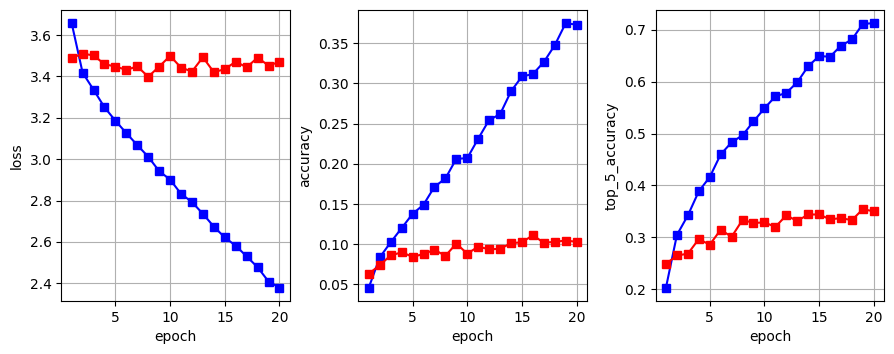

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3.5))
fig.tight_layout(); plt.subplots_adjust(wspace=0.3)
xx = np.arange(1, len(history.history['loss'])+1)
ax = axes[0]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('loss')
ax.plot(xx, history.history['loss'], color='b', marker='s')
ax.plot(xx, history.history['val_loss'], color='r', marker='s')
ax = axes[1]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('accuracy')
ax.plot(xx, history.history['accuracy'], color='b', marker='s')
ax.plot(xx, history.history['val_accuracy'], color='r', marker='s');
ax = axes[2]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('top_5_accuracy')
ax.plot(xx, history.history['top_5_accuracy'], color='b', marker='s')
ax.plot(xx, history.history['val_top_5_accuracy'], color='r', marker='s');

The baseline model, a simple Multilayer Perceptron (MLP), was evaluated on the test set with the following results:

* Test Loss: 3.5518 \\
  The high test loss suggests that the model's predictions are far from the actual labels, indicating poor performance in learning from the data.

* Test Accuracy: 0.0851 (8.51%) \\
  This low accuracy shows that the model correctly identified only about 10% of the images, which is only marginally better than random guessing in a 37-class problem.

* Test Top-5 Accuracy: 0.3479 (34.79%) \\
  The Top-5 accuracy is higher, with the correct class appearing in the top 5 predictions 34.59% of the time, suggesting that while the model often misses the exact class, it is somewhat capable of narrowing down the correct options.

These baseline results are expected for a simple MLP model and will serve as a benchmark for improvement in subsequent, more sophisticated models.

## 2.Tuning the architecture to optimize the performance

Next, the goal is to adjust the architecture by utilizing **Keras Tuner** to experiment with different configurations of layers and units. This approach will allow testing a varying number of layers (between 1 and 3) and units per layer (ranging from 512 to 1024) to identify the optimal structure for improved performance. This tuning process aims to find the best balance between model complexity and accuracy.

A total of 15 trials will be generated, and the best model will be selected based on validation accuracy. This tuning process aims to find the right balance between model complexity and accuracy. The number of trials is not sufficient to inspect all different combination of the parameters, but due to hardware limitations and time constrictions it should suffice at this point.

In [ ]:
class MyHyperModel(keras_tuner.HyperModel):
    def build(self, hp):
        model = keras.Sequential()
        model.add(keras.Input(shape=(64, 64, 3)))
        model.add(layers.Flatten())
        for i in range(hp.Int('num_layers', 1, 3)):
            units = hp.Int(f'units_{i}', min_value=512, max_value=1024, step=128)
            model.add(layers.Dense(units=units, activation='relu'))
        model.add(layers.Dense(num_classes, activation='softmax'))

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            loss='sparse_categorical_crossentropy',
            metrics=[
                'accuracy',
                SparseTopKCategoricalAccuracy(k=5, name='top_5_accuracy')
            ],
        )
        return model

In [ ]:
tuner = keras_tuner.BayesianOptimization(
    hypermodel=MyHyperModel(),
    objective='val_accuracy',
    max_trials=15,
    executions_per_trial=1,
    directory='/tmp',
    project_name='oxford_pets_tuning',
    overwrite=True
)

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 512, 'max_value': 1024, 'step': 128, 'sampling': 'linear'}


In [ ]:
tuner.search(ds_train, batch_size=BATCH_SIZE, epochs=10, validation_data=ds_val)


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
2                 |2                 |num_layers
512               |512               |units_0

Epoch 1/10


In [ ]:
tuner.results_summary(num_trials=1)

In [ ]:
best = tuner.get_best_models(num_models=1)[0]
score = best.evaluate(ds_test)
print(f'Loss: {score[0]:.4}\nAccuracy: {score[1]:.1%}\nTop-5 Accuracy: {score[2]:.1%}')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.1016 - loss: 3.3358 - top_5_accuracy: 0.3708
Loss: 3.353
Accuracy: 10.6%
Top-5 Accuracy: 37.5%


In [ ]:
model = MyHyperModel()
model = model.build(tuner.get_best_hyperparameters(1)[0])
history = model.fit(ds_train, validation_data=ds_val, epochs=20, batch_size=BATCH_SIZE, verbose=0)

Epoch 1/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.0424 - loss: 3.6409 - top_5_accuracy: 0.1670 - val_accuracy: 0.0583 - val_loss: 3.5299 - val_top_5_accuracy: 0.2409
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.0595 - loss: 3.4564 - top_5_accuracy: 0.2646 - val_accuracy: 0.0692 - val_loss: 3.4537 - val_top_5_accuracy: 0.2687
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.0856 - loss: 3.3859 - top_5_accuracy: 0.2987 - val_accuracy: 0.0583 - val_loss: 3.4553 - val_top_5_accuracy: 0.2676
Epoch 4/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.0965 - loss: 3.3424 - top_5_accuracy: 0.3378 - val_accuracy: 0.0861 - val_loss: 3.4450 - val_top_5_accuracy: 0.2997
Epoch 5/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.1111 - loss: 3.2596 - top_5_accuracy: 0.3758 - val_accuracy: 0.0801 - val_loss: 3.4065 - val_top_5_accuracy: 0.3106
Epoch 6/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.1276 - loss: 3.167

In [ ]:
test_loss, test_accuracy, test_top5_accuracy = model.evaluate(ds_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Top-5 Accuracy: {test_top5_accuracy:.4f}")

58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.0942 - loss: 3.7761 - top_5_accuracy: 0.3540
Test Loss: 3.7791
Test Accuracy: 0.1003
Test Top-5 Accuracy: 0.3495


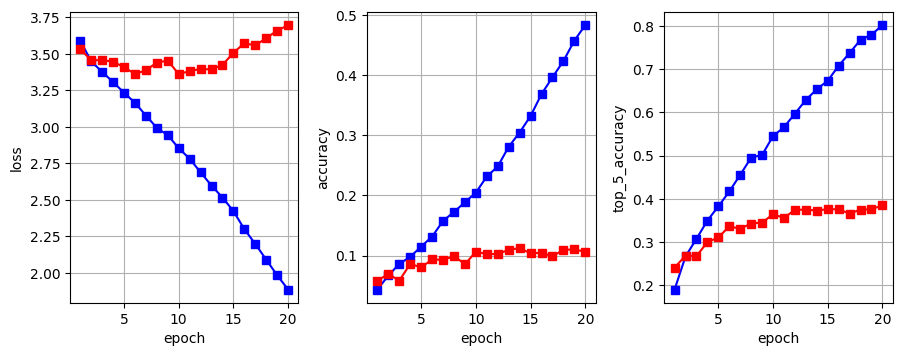

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3.5))
fig.tight_layout(); plt.subplots_adjust(wspace=0.3)
xx = np.arange(1, len(history.history['loss'])+1)
ax = axes[0]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('loss')
ax.plot(xx, history.history['loss'], color='b', marker='s')
ax.plot(xx, history.history['val_loss'], color='r', marker='s')
ax = axes[1]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('accuracy')
ax.plot(xx, history.history['accuracy'], color='b', marker='s')
ax.plot(xx, history.history['val_accuracy'], color='r', marker='s');
ax = axes[2]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('top_5_accuracy')
ax.plot(xx, history.history['top_5_accuracy'], color='b', marker='s')
ax.plot(xx, history.history['val_top_5_accuracy'], color='r', marker='s');

Best Architecture:

* Number of layers: 3
* Units in Layer 1: 512
* Units in Layer 2: 768
* Units in Layer 3: 1024
* Activation Function: ReLU for all layers
* Output: Softmax for classification

Results:

* Test Loss: 3.353
* Test Accuracy: 10.6% (indicating slight improvement in overall accuracy)
* Top-5 Accuracy: 37.5% (suggesting better performance in identifying correct classes within the top 5 predictions) \\

This architecture provides a more complex structure, leading to minor improvements over the baseline.

## 3.Hyperparameter adjustments to improve learning.

In this section, the architecture from the previous stage was selected for further refinement by optimizing key hyperparameters, including the learning rate and batch size, to improve the model’s performance.

* Learning Rate Tuning: \\
The learning rate is now a tunable hyperparameter, ranging from 0.00005 to 0.00015, allowing for fine adjustments to the model’s learning process using the Adam optimizer.

* Batch Size Tuning: \\
The batch size is also optimized, ranging from 32 to 256, to find the most effective batch size for training.

* Early Stopping: \\
Early stopping is implemented to monitor validation accuracy and halt training if performance does not improve after 10 epochs, reducing overfitting.

The goal of these adjustments is to further improve the model’s ability to generalize while optimizing training efficiency by finding the most effective learning rate and batch size for the architecture.

In [ ]:
class MyHyperModel(keras_tuner.HyperModel):
    def build(self, hp):
        model = keras.Sequential()
        model.add(keras.Input(shape=(64,64,3)))
        model.add(layers.Flatten())
        model.add(layers.Dense(units=512, activation='relu'))
        model.add(layers.Dense(units=768, activation='relu'))
        model.add(layers.Dense(units=1024, activation='relu'))
        model.add(layers.Dense(num_classes, activation='softmax'))
        learning_rate= hp.Float("lr", min_value=0.00005, max_value=0.00015)
        opt = keras.optimizers.Adam(learning_rate=learning_rate)
        model.compile(
            optimizer=opt,
            loss='sparse_categorical_crossentropy',
            metrics=[
                'accuracy',
                SparseTopKCategoricalAccuracy(k=5, name='top_5_accuracy')],
        )
        return model

    def fit(self, hp, model, x, validation_data=None, **kwargs):
        batch_size = hp.Int('batch_size', min_value=32, max_value=256, step=32, sampling='linear')

        early_cb = keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            min_delta=1e-5
        )
        kwargs['callbacks'].append(early_cb)
        return model.fit(
            x,
            batch_size=batch_size,
            validation_data=validation_data,
            **kwargs
        )

In [ ]:
tuner = keras_tuner.BayesianOptimization(
    hypermodel=MyHyperModel(), objective="val_accuracy", max_trials=15,
    overwrite=True, directory="/tmp", project_name="oxford_pets_tuning"
)

In [ ]:
tuner.search(ds_train, ds_val, epochs=10)

Trial 15 Complete [00h 00m 31s]
val_accuracy: 0.09863760322332382

Best val_accuracy So Far: 0.1138964593410492
Total elapsed time: 00h 07m 47s


In [ ]:
tuner.results_summary(num_trials=1)

Results summary
Results in /tmp/oxford_pets_tuning
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 13 summary
Hyperparameters:
lr: 0.00013215643764173714
batch_size: 256
Score: 0.1138964593410492


In [ ]:
best = tuner.get_best_models(num_models=1)[0]
score = best.evaluate(ds_test)
print(f'Loss: {score[0]:.4}\nAccuracy: {score[1]:.2%}')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.1020 - loss: 3.3774 - top_5_accuracy: 0.3612
Loss: 3.397
Accuracy: 10.80%


In [ ]:
model = MyHyperModel()
model = model.build(tuner.get_best_hyperparameters(1)[0])
history = model.fit(ds_train, validation_data=ds_val, epochs=20)

Epoch 1/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.0387 - loss: 3.6455 - top_5_accuracy: 0.1759 - val_accuracy: 0.0736 - val_loss: 3.4756 - val_top_5_accuracy: 0.2474
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.0601 - loss: 3.4603 - top_5_accuracy: 0.2630 - val_accuracy: 0.0659 - val_loss: 3.4792 - val_top_5_accuracy: 0.2463
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.0826 - loss: 3.3763 - top_5_accuracy: 0.3132 - val_accuracy: 0.0730 - val_loss: 3.4208 - val_top_5_accuracy: 0.2943
Epoch 4/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.1024 - loss: 3.3168 - top_5_accuracy: 0.3453 - val_accuracy: 0.0785 - val_loss: 3.4355 - val_top_5_accuracy: 0.2763
Epoch 5/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.1096 - loss: 3.2503 - top_5_accuracy: 0.3641 - val_accuracy: 0.0856 - val_loss: 3.3676 - val_top_5_accuracy: 0.3128
Epoch 6/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.1296 - loss: 3.175

In [ ]:
test_loss, test_accuracy, test_top5_accuracy = model.evaluate(ds_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Top-5 Accuracy: {test_top5_accuracy:.4f}")

58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.0949 - loss: 3.8666 - top_5_accuracy: 0.3626
Test Loss: 3.8861
Test Accuracy: 0.0971
Test Top-5 Accuracy: 0.3511


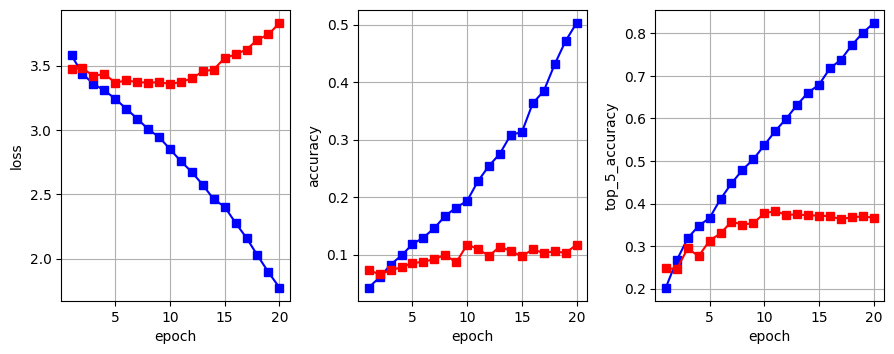

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3.5))
fig.tight_layout(); plt.subplots_adjust(wspace=0.3)
xx = np.arange(1, len(history.history['loss'])+1)
ax = axes[0]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('loss')
ax.plot(xx, history.history['loss'], color='b', marker='s')
ax.plot(xx, history.history['val_loss'], color='r', marker='s')
ax = axes[1]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('accuracy')
ax.plot(xx, history.history['accuracy'], color='b', marker='s')
ax.plot(xx, history.history['val_accuracy'], color='r', marker='s');
ax = axes[2]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('top_5_accuracy')
ax.plot(xx, history.history['top_5_accuracy'], color='b', marker='s')
ax.plot(xx, history.history['val_top_5_accuracy'], color='r', marker='s');

Hyperparameters:

* Learning Rate: 0.000132
* Batch Size: 256

Results:

* Test Loss: 3.397
* Test Accuracy: 0.0971
* Top-5 Accuracy: 0.3511

The results suggest that the model is overfitting to the training data and is unable to generalize well to unseen data. Despite optimizing hyperparameters, the test loss of 3.8861, test accuracy of 9.71%, and Top-5 accuracy of 35.11% indicate that the model is struggling to capture meaningful patterns that generalize beyond the training set. Further strategies, such as regularization or increasing data diversity, may be necessary to address this issue.

### Regularization

In this model, several ideas and techniques were applied to address overfitting and improve generalization:

1. Kernel Initialization and Regularization: A RandomNormal initializer was used for the weights, with a tunable standard deviation to explore different initialization strategies.
L2 Regularization was applied to the dense layers, with a tunable regularization factor to penalize large weights, helping to reduce overfitting.

2. Dropout: A dropout layer with a tunable dropout rate (between 6% and 20%) was added to prevent overfitting by randomly deactivating a portion of the neurons during training, forcing the model to learn more robust features.

3. Learning Rate and Optimizer: The learning rate of the Adam optimizer was tuned within a range (0.00005 to 0.00015) to find the optimal learning speed for better convergence.

4. ReduceLROnPlateau: A ReduceLROnPlateau callback was included to lower the learning rate if validation accuracy plateaued, with a tunable factor and patience. This prevents the model from getting stuck in suboptimal learning.

5. Early Stopping: An EarlyStopping callback was applied to stop training if validation accuracy stopped improving for a certain number of epochs (with patience set as a tunable parameter), preventing overfitting by halting training when further learning doesn't yield significant gains.

In [ ]:
class MyHyperModel(keras_tuner.HyperModel):
    def build(self, hp):
        model = keras.Sequential()
        model.add(keras.Input(shape=(64, 64, 3)))
        stddev = hp.Float("stddev", min_value=0.01, max_value=0.10)
        kernel_initializer = keras.initializers.RandomNormal(stddev=stddev)
        l2_reg = hp.Float("l2_reg", min_value=1e-5, max_value=1e-2, sampling="log")
        dropout_rate = hp.Float("dropout_rate", min_value=0.06, max_value=0.2, step=0.02)
        model.add(layers.Flatten())
        model.add(layers.Dense(units=512, activation='relu',
                  kernel_regularizer=keras.regularizers.l2(l2_reg),
                  kernel_initializer=kernel_initializer))
        model.add(layers.Dense(units=768, activation='relu',
                  kernel_regularizer=keras.regularizers.l2(l2_reg),
                  kernel_initializer=kernel_initializer))
        model.add(layers.Dense(units=1024, activation='relu',
          kernel_regularizer=keras.regularizers.l2(l2_reg),
          kernel_initializer=kernel_initializer))
        model.add(layers.Dropout(rate=dropout_rate))
        model.add(layers.Dense(num_classes, activation='softmax'))

        learning_rate= hp.Float("lr", min_value=0.00005, max_value=0.00015)
        opt = keras.optimizers.Adam(learning_rate=learning_rate)
        model.compile(
            loss="sparse_categorical_crossentropy",
            optimizer=opt,
            metrics=["accuracy",
                SparseTopKCategoricalAccuracy(k=5, name='top_5_accuracy')])
        return model

    def fit(self, hp, model, x, y=None, validation_data=None, **kwargs):
        factor = hp.Float("factor", min_value=0.05, max_value=0.2)
        patience = hp.Choice("patience", [2, 5, 10])
        reduce_cb = keras.callbacks.ReduceLROnPlateau(
            monitor='val_accuracy', factor=factor, patience=patience,
            min_delta=1e-4, min_lr=1e-5)
        early_cb = keras.callbacks.EarlyStopping(
            monitor='val_accuracy', patience=2 * patience, min_delta=1e-5)
        kwargs['callbacks'].extend([reduce_cb, early_cb])

        return model.fit(x, y, batch_size=64,
                validation_data=validation_data, **kwargs)

In [ ]:
tuner = keras_tuner.BayesianOptimization(
    MyHyperModel(), objective="val_accuracy",
    max_trials=15, overwrite=True,
    directory="/tmp", project_name="oxford_pets_tuning"
)

In [ ]:
tuner.search(ds_train, validation_data=ds_val, epochs=10)

Trial 15 Complete [00h 00m 33s]
val_accuracy: 0.10136239975690842

Best val_accuracy So Far: 0.10626702755689621
Total elapsed time: 00h 08m 27s


In [ ]:
tuner.results_summary(num_trials=1)

Results summary
Results in /tmp/oxford_pets_tuning
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 05 summary
Hyperparameters:
stddev: 0.03448008824474408
l2_reg: 6.989571119848848e-05
dropout_rate: 0.2
lr: 0.0001316707352090875
factor: 0.08983800107112039
patience: 2
Score: 0.10626702755689621


In [ ]:
best = tuner.get_best_models(num_models=1)[0]
score = best.evaluate(ds_test)
print(f'Loss: {score[0]:.4}\nAccuracy: {score[1]:.2%}')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.0850 - loss: 3.8102 - top_5_accuracy: 0.3735
Loss: 3.824
Accuracy: 9.87%


In [ ]:
model = MyHyperModel()
model = model.build(tuner.get_best_hyperparameters(1)[0])
history = model.fit(ds_train, validation_data=ds_val, epochs=20, batch_size=64, verbose=0)

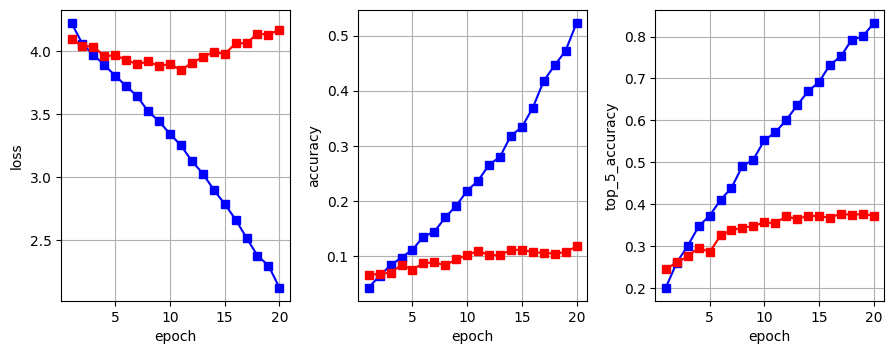

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3.5))
fig.tight_layout(); plt.subplots_adjust(wspace=0.3)
xx = np.arange(1, len(history.history['loss'])+1)
ax = axes[0]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('loss')
ax.plot(xx, history.history['loss'], color='b', marker='s')
ax.plot(xx, history.history['val_loss'], color='r', marker='s')
ax = axes[1]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('accuracy')
ax.plot(xx, history.history['accuracy'], color='b', marker='s')
ax.plot(xx, history.history['val_accuracy'], color='r', marker='s');
ax = axes[2]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('top_5_accuracy')
ax.plot(xx, history.history['top_5_accuracy'], color='b', marker='s')
ax.plot(xx, history.history['val_top_5_accuracy'], color='r', marker='s');

In [ ]:
test_loss, test_accuracy, test_top5_accuracy = model.evaluate(ds_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Top-5 Accuracy: {test_top5_accuracy:.4f}")

58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.0926 - loss: 4.2833 - top_5_accuracy: 0.3519
Test Loss: 4.2763
Test Accuracy: 0.0976
Test Top-5 Accuracy: 0.3473


Hyperparameters:

* Standard Deviation (stddev): 0.03448
* L2 Regularization (l2_reg): 6.98957e-05
* Dropout Rate: 0.2
* Learning Rate: 0.00013167
* Factor (for ReduceLROnPlateau): 0.089838
* Patience: 2

Results:

* Test Loss: 4.2763
* Test Accuracy: 9.76% (showing no improvement over previous models)
* Test Top-5 Accuracy: 34.73% (slightly lower than before)

Despite applying various regularization techniques and hyperparameter tuning, the model continues to struggle with generalization, as indicated by low test accuracy and a relatively high test loss. This suggests that further adjustments, such as more complex architectures, additional data augmentation, or refined hyperparameter ranges, may be necessary to achieve better results.

## 4.Implementation of CNNs

In this next step, a Convolutional Neural Network (CNN) architecture is introduced to enhance the model’s ability to learn spatial features. Key adjustments include:

* Convolutional Layers: Two Conv2D layers with tunable filters (16-64) and MaxPooling to reduce dimensionality, followed by Batch Normalization for training stability.

* Dense Layer: A tunable Dense layer (400-800 units) with Dropout (0.1-0.3) to prevent overfitting.

* Learning Rate and Regularization: Tunable learning rate (1e-5 to 1e-3) for the Adam optimizer, with L2 regularization to avoid overfitting.

* Callbacks: ReduceLROnPlateau and EarlyStopping are used to adapt learning rate and stop training early if performance plateaus.

* Batch Size: Tunable between 16 and 64.



In [ ]:
class MyHyperModel(keras_tuner.HyperModel):

    def build(self, hp):
        factor = hp.Float('factor', min_value=0.1, max_value=0.5, step=0.1)
        patience = hp.Int('patience', min_value=2, max_value=10, step=2)
        l2_reg = hp.Float("l2_reg", min_value=1e-5, max_value=1e-2, sampling="log")
        model = keras.Sequential()
        model.add(keras.Input(shape=(64, 64, 3)))

        num_filters = hp.Int('num_filters', min_value=16, max_value=64, step=16)
        model.add(keras.layers.Conv2D(num_filters, kernel_size=(3, 3), activation='relu',
                  kernel_initializer=keras.initializers.HeUniform(),
                  kernel_regularizer=keras.regularizers.l2(l2_reg)))
        model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(keras.layers.Conv2D(num_filters * 2, kernel_size=(3, 3), activation='relu',
                  kernel_initializer=keras.initializers.HeUniform(),
                  kernel_regularizer=keras.regularizers.l2(l2_reg)))
        model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.BatchNormalization())

        model.add(keras.layers.Flatten())
        units = hp.Int('units', min_value=400, max_value=800, step=100)
        model.add(keras.layers.Dense(units=units, activation='relu',
                  kernel_initializer=keras.initializers.HeUniform()))
        model.add(layers.Dropout(rate=hp.Float('dropout_rate', 0.1, 0.3, step=0.1)))

        model.add(keras.layers.Dense(num_classes, activation='softmax',
                        kernel_initializer=keras.initializers.HeUniform()))

        learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='log')
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

        reduce_lr = keras.callbacks.ReduceLROnPlateau(
          monitor='val_accuracy',
          factor=factor,
          patience=patience,
          min_delta=1e-4,
          min_lr=1e-6)

        batch_size = hp.Int('batch_size', min_value=16, max_value=64, step=16)
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy',
                    SparseTopKCategoricalAccuracy(k=5, name='top_5_accuracy')]
        )
        return model

    def fit(self, hp, model, x, y=None, validation_data=None, **kwargs):
        factor = hp.Float('factor', min_value=0.1, max_value=0.5, step=0.1)
        patience = hp.Int('patience', min_value=2, max_value=10, step=2)

        reduce_cb = keras.callbacks.ReduceLROnPlateau(
            monitor='val_accuracy',
            factor=factor,
            patience=patience,
            min_delta=1e-4,
            min_lr=1e-6)

        early_cb = keras.callbacks.EarlyStopping(
          monitor='val_accuracy',
          patience=5,
          restore_best_weights=True)

        batch_size = hp.Int('batch_size', min_value=16, max_value=64, step=16)
        kwargs['callbacks'].extend([reduce_cb, early_cb])
        return model.fit(
            x, y,
            batch_size=batch_size,
            validation_data=validation_data,
            **kwargs
        )

In [ ]:
tuner = keras_tuner.BayesianOptimization(
    MyHyperModel(),
    objective='val_accuracy',
    max_trials=15,
    executions_per_trial=1,
    overwrite=True,
    directory='/tmp',
    project_name='oxford_pets_cnn'
)

In [ ]:
tuner.search(ds_train, validation_data=ds_val, epochs=10)

Trial 15 Complete [00h 00m 39s]
val_accuracy: 0.1634877324104309

Best val_accuracy So Far: 0.18801090121269226
Total elapsed time: 00h 09m 14s


In [ ]:
tuner.results_summary(num_trials=4)

Results summary
Results in /tmp/oxford_pets_cnn
Showing 4 best trials
Objective(name="val_accuracy", direction="max")

Trial 05 summary
Hyperparameters:
factor: 0.1
patience: 6
l2_reg: 1.076410128925281e-05
num_filters: 64
units: 600
dropout_rate: 0.1
learning_rate: 0.00017756127466446613
batch_size: 32
Score: 0.18801090121269226

Trial 09 summary
Hyperparameters:
factor: 0.2
patience: 10
l2_reg: 0.001339795892001461
num_filters: 32
units: 400
dropout_rate: 0.1
learning_rate: 0.00046401888886033404
batch_size: 64
Score: 0.18528610467910767

Trial 11 summary
Hyperparameters:
factor: 0.1
patience: 8
l2_reg: 1.8196615119335303e-05
num_filters: 48
units: 600
dropout_rate: 0.2
learning_rate: 0.00020509538701765314
batch_size: 32
Score: 0.18201634287834167

Trial 10 summary
Hyperparameters:
factor: 0.5
patience: 4
l2_reg: 0.00014307666528640437
num_filters: 64
units: 600
dropout_rate: 0.1
learning_rate: 4.816477845245377e-05
batch_size: 32
Score: 0.17929154634475708


In [ ]:
num_models = 10
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=num_models)
best_models = tuner.get_best_models(num_models=num_models)
for m in range(num_models):
  values = best_hyperparameters[m].values
  score = best_models[m].evaluate(ds_test, verbose=0)
  print(f'Model {m}: Hyperparameters: {values!s} Loss: {score[0]:.4} Accuracy: {score[1]:.2%}') #Top-5 Accuracy: {score[2]:.2%}

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model 0: Hyperparameters: {'factor': 0.1, 'patience': 6, 'l2_reg': 1.076410128925281e-05, 'num_filters': 64, 'units': 600, 'dropout_rate': 0.1, 'learning_rate': 0.00017756127466446613, 'batch_size': 32} Loss: 4.093 Accuracy: 16.47%
Model 1: Hyperparameters: {'factor': 0.2, 'patience': 10, 'l2_reg': 0.001339795892001461, 'num_filters': 32, 'units': 400, 'dropout_rate': 0.1, 'learning_rate': 0.00046401888886033404, 'batch_size': 64} Loss: 4.478 Accuracy: 16.52%
Model 2: Hyperparameters: {'factor': 0.1, 'patience': 8, 'l2_reg': 1.8196615119335303e-05, 'num_filters': 48, 'units': 600, 'dropout_rate': 0.2, 'learning_rate': 0.00020509538701765314, 'batch_size': 32} Loss: 4.236 Accuracy: 16.36%
Model 3: Hyperparameters: {'factor': 0.5, 'patience': 4, 'l2_reg': 0.00014307666528640437, 'num_filters': 64, 'units': 600, 'dropout_rate': 0.1, 'learning_rate': 4.816477845245377e-05, 'batch_size': 32} Loss: 3.695 Accuracy: 15.87%
Model 4: Hyperparameters: {'factor': 0.4, 'patience': 10, 'l2_reg': 0.0

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
cnn_model_params = tuner.get_best_hyperparameters(num_trials=1)[0] #saving for later

test_loss, test_accuracy, test_top5accuracy = best_model.evaluate(ds_test)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4%}')

58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.1597 - loss: 4.1633 - top_5_accuracy: 0.4562
Test Loss: 4.0934
Test Accuracy: 16.4667%


In [ ]:
model = MyHyperModel()
model = model.build(tuner.get_best_hyperparameters(1)[0])
history = model.fit(ds_train, validation_data=ds_val, epochs=20, verbose=0)

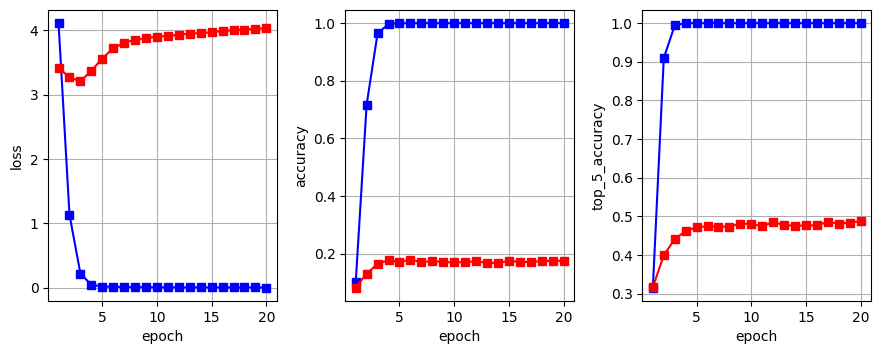

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3.5))
fig.tight_layout(); plt.subplots_adjust(wspace=0.3)
xx = np.arange(1, len(history.history['loss'])+1)
ax = axes[0]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('loss')
ax.plot(xx, history.history['loss'], color='b', marker='s')
ax.plot(xx, history.history['val_loss'], color='r', marker='s')
ax = axes[1]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('accuracy')
ax.plot(xx, history.history['accuracy'], color='b', marker='s')
ax.plot(xx, history.history['val_accuracy'], color='r', marker='s');
ax = axes[2]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('top_5_accuracy')
ax.plot(xx, history.history['top_5_accuracy'], color='b', marker='s')
ax.plot(xx, history.history['val_top_5_accuracy'], color='r', marker='s');

In [ ]:
test_loss, test_accuracy,test_top5_accuracy = model.evaluate(ds_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Top-5 Accuracy: {test_top5_accuracy:.4f}")

58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.1800 - loss: 4.0766 - top_5_accuracy: 0.4909
Test Loss: 4.1023
Test Accuracy: 0.1756
Test Top-5 Accuracy: 0.4787


Best Hyperparameters:

* Factor (ReduceLROnPlateau): 0.1
* Patience: 6
* L2 Regularization: 1.08e-05
* Number of Filters: 64
* Units in Dense Layer: 600
* Dropout Rate: 0.1
* Learning Rate: 0.000177
* Batch Size: 32

Results:

* Test Loss: 4.1023
* Test Accuracy: 17.56% (improved performance over previous models)
* Test Top-5 Accuracy: 47.87% (showing a better ability to identify the correct class within the top 5 predictions)

These hyperparameters yielded the best results so far, indicating that the CNN architecture improves the model's ability to extract features, although further refinement is needed to achieve better accuracy.

## 5.Transfer Learning

For this section, the model utilizes Transfer Learning by leveraging the MobileNetV2 architecture, which is pretrained on ImageNet, to improve performance on the task. Here are the key steps and adjustments made:

* Base Model: The MobileNetV2 model, pretrained on ImageNet, is used as the feature extractor. The top layer is excluded (include_top=False), and the model’s weights are frozen (trainable=False), allowing the pretrained features to be reused for the specific dataset without updating them during training.

* Custom Layers: After the base model, additional layers are added to fine-tune the model for the classification task:

    1. A GlobalAveragePooling2D layer to reduce the spatial dimensions and flatten the output.
    2. A Dense layer with 800 units and ReLU activation to learn high-level features.
    3. A Dropout layer (0.5) to mitigate overfitting by randomly dropping some neurons during training.
    4. BatchNormalization to stabilize and normalize the layer activations.
    5. A final Dense layer with a softmax activation for multi-class classification.

* Optimizer and Learning Rate: The model is trained using the Adam optimizer with a learning rate of 0.001, which ensures efficient updates to the network during training.

* Callbacks:
  - ModelCheckpoint to save the best model based on validation accuracy.
  - ReduceLROnPlateau to decrease the learning rate when validation accuracy plateaus, using a factor of 0.3 and patience of 5 epochs.
  - EarlyStopping to halt training if validation accuracy doesn't improve after 5 epochs, avoiding unnecessary training.
* Training Setup: The model is trained for 100 epochs, with a batch size of 32, and is evaluated based on both accuracy and Top-5 accuracy.

This approach enables the use of powerful pretrained features from MobileNetV2 while fine-tuning the final layers to adapt to the specific dataset.

In [ ]:
base_model = keras.applications.MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
base_model.trainable = False

<ipython-input-65-ce036068b369>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = keras.applications.MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(units=800, activation='relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(num_classes, activation='softmax')])

opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy",
                              SparseTopKCategoricalAccuracy(k=5, name='top_5_accuracy')])

In [ ]:
filename = 'MobileNetV2.keras'
checkpoint_cb = keras.callbacks.ModelCheckpoint(
filepath=filename, monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_cb = keras.callbacks.ReduceLROnPlateau(
  monitor='val_accuracy', factor=0.3, patience=5, min_delta=0.0005, min_lr=0.0)
early_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.0005)
history = model.fit(ds_train, batch_size=32, epochs=100, validation_data=ds_val, verbose=0,
callbacks=[checkpoint_cb, early_cb, reduce_cb])


Epoch 1: val_accuracy improved from -inf to 0.34659, saving model to MobileNetV2.keras

Epoch 2: val_accuracy improved from 0.34659 to 0.35695, saving model to MobileNetV2.keras

Epoch 3: val_accuracy did not improve from 0.35695

Epoch 4: val_accuracy improved from 0.35695 to 0.35804, saving model to MobileNetV2.keras

Epoch 5: val_accuracy improved from 0.35804 to 0.36240, saving model to MobileNetV2.keras

Epoch 6: val_accuracy improved from 0.36240 to 0.36349, saving model to MobileNetV2.keras

Epoch 7: val_accuracy did not improve from 0.36349

Epoch 8: val_accuracy did not improve from 0.36349

Epoch 9: val_accuracy did not improve from 0.36349

Epoch 10: val_accuracy improved from 0.36349 to 0.36567, saving model to MobileNetV2.keras

Epoch 11: val_accuracy did not improve from 0.36567

Epoch 12: val_accuracy did not improve from 0.36567

Epoch 13: val_accuracy did not improve from 0.36567

Epoch 14: val_accuracy improved from 0.36567 to 0.36785, saving model to MobileNetV2.ker

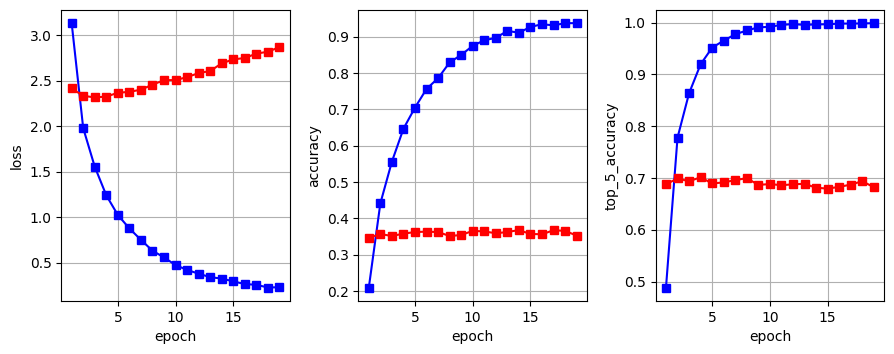

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3.5))
fig.tight_layout(); plt.subplots_adjust(wspace=0.3)
xx = np.arange(1, len(history.history['loss'])+1)
ax = axes[0]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('loss')
ax.plot(xx, history.history['loss'], color='b', marker='s')
ax.plot(xx, history.history['val_loss'], color='r', marker='s')
ax = axes[1]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('accuracy')
ax.plot(xx, history.history['accuracy'], color='b', marker='s')
ax.plot(xx, history.history['val_accuracy'], color='r', marker='s');
ax = axes[2]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('top_5_accuracy')
ax.plot(xx, history.history['top_5_accuracy'], color='b', marker='s')
ax.plot(xx, history.history['val_top_5_accuracy'], color='r', marker='s');

In [ ]:
score = model.evaluate(ds_test)
print(f'Test Loss: {score[0]:.4f}')
print(f'Test Accuracy: {score[1]:.4f}')
print(f'Test Top-5 Accuracy: {score[2]:.4f}')

58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.3367 - loss: 2.9090 - top_5_accuracy: 0.6714
Test Loss: 2.9321
Test Accuracy: 0.3288
Test Top-5 Accuracy: 0.6647


Results:

* Test Loss: 2.9321
* Test Accuracy: 32.88%
* Test Top-5 Accuracy: 66.47%

These results indicate a significant improvement compared to previous models. The use of Transfer Learning with MobileNetV2 has improved the model's ability to generalize, as seen from the higher test accuracy and Top-5 accuracy. The Top-5 accuracy of 66.47% suggests that the model is correctly identifying the true class within the top 5 predictions in a large majority of cases, showcasing the effectiveness of leveraging pretrained networks for complex image classification tasks.

## 6.Fine-Tuning

In this section, fine-tuning is applied to the MobileNetV2 model. The main change compared to the previous transfer learning step is that the base model's layers are now trainable (except for batch normalization layers), allowing the pretrained network to adapt further to the dataset. The custom layers, optimizer, learning rate, and callbacks remain largely the same, with the learning rate set to 0.0001 for controlled updates. This step aims to improve model performance by adjusting the pretrained weights during training.

In [ ]:
base_model = keras.applications.MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
base_model.trainable = True
for layer in base_model.layers:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

<ipython-input-70-d897b10e0464>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = keras.applications.MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')


In [ ]:
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(units=800, activation='relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(num_classes, activation='softmax')])

opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy",
                              SparseTopKCategoricalAccuracy(k=5, name='top_5_accuracy')])

In [ ]:
filename = 'MobileNetV2.keras'
checkpoint_cb = keras.callbacks.ModelCheckpoint(
filepath=filename, monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_cb = keras.callbacks.ReduceLROnPlateau(
  monitor='val_accuracy', factor=0.3, patience=5, min_delta=0.0005, min_lr=0.0)
early_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.0005)
history = model.fit(ds_train, batch_size=32, epochs=100, validation_data=ds_val, verbose=0,
callbacks=[checkpoint_cb, early_cb, reduce_cb])


Epoch 1: val_accuracy improved from -inf to 0.09428, saving model to MobileNetV2.keras

Epoch 2: val_accuracy improved from 0.09428 to 0.15640, saving model to MobileNetV2.keras

Epoch 3: val_accuracy improved from 0.15640 to 0.22016, saving model to MobileNetV2.keras

Epoch 4: val_accuracy improved from 0.22016 to 0.23270, saving model to MobileNetV2.keras

Epoch 5: val_accuracy improved from 0.23270 to 0.26866, saving model to MobileNetV2.keras

Epoch 6: val_accuracy improved from 0.26866 to 0.27302, saving model to MobileNetV2.keras

Epoch 7: val_accuracy improved from 0.27302 to 0.28065, saving model to MobileNetV2.keras

Epoch 8: val_accuracy improved from 0.28065 to 0.28719, saving model to MobileNetV2.keras

Epoch 9: val_accuracy improved from 0.28719 to 0.31008, saving model to MobileNetV2.keras

Epoch 10: val_accuracy improved from 0.31008 to 0.33134, saving model to MobileNetV2.keras

Epoch 11: val_accuracy did not improve from 0.33134

Epoch 12: val_accuracy improved from 0

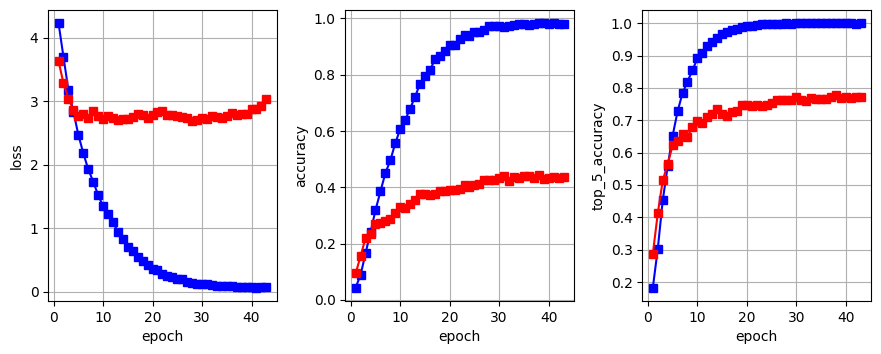

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3.5))
fig.tight_layout(); plt.subplots_adjust(wspace=0.3)
xx = np.arange(1, len(history.history['loss'])+1)
ax = axes[0]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('loss')
ax.plot(xx, history.history['loss'], color='b', marker='s')
ax.plot(xx, history.history['val_loss'], color='r', marker='s')
ax = axes[1]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('accuracy')
ax.plot(xx, history.history['accuracy'], color='b', marker='s')
ax.plot(xx, history.history['val_accuracy'], color='r', marker='s');
ax = axes[2]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('top_5_accuracy')
ax.plot(xx, history.history['top_5_accuracy'], color='b', marker='s')
ax.plot(xx, history.history['val_top_5_accuracy'], color='r', marker='s');

In [ ]:
score = model.evaluate(ds_test)
print(f'Test Loss: {score[0]:.4f}')
print(f'Test Accuracy: {score[1]:.4f}')
print(f'Test Top-5 Accuracy: {score[2]:.4f}')

58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.4278 - loss: 3.1083 - top_5_accuracy: 0.7638
Test Loss: 3.1839
Test Accuracy: 0.4062
Test Top-5 Accuracy: 0.7568


Results:

* Test Loss: 3.1839
* Test Accuracy: 40.62%
* Test Top-5 Accuracy: 75.68%

These results show a noticeable improvement over the previous model, particularly in Test Accuracy and Top-5 Accuracy. Fine-tuning has allowed the model to better adapt to the dataset, significantly increasing its ability to correctly classify images, especially when considering the Top-5 accuracy, which indicates stronger overall performance.

## 7.Data Augmentation

### Transfer Learning with Data Augmentation

In this section, data augmentation techniques were applied to improve model generalization and prevent overfitting. The following changes were made:

Data Augmentation:
* Random horizontal flips of the images.
* Random rotations by up to 20%.
* Random zooms by up to 20%.
* Random contrast adjustments by up to 20%.

These transformations were added as a preprocessing step before the base model, ensuring more diverse training data and better robustness to variations in the input.

The rest of the model remains largely the same, including the use of the MobileNetV2 base model, custom layers, optimizer, learning rate, and callbacks. This section focuses on improving performance by increasing the variability in the training set.

In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),         # Randomly flip images horizontally
    layers.RandomRotation(0.2),              # Rotate images by 20%
    layers.RandomZoom(0.2),                  # Zoom by up to 20%
    layers.RandomContrast(0.2),              # Adjust contrast
])

In [ ]:
model = keras.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(units=800, activation='relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(num_classes, activation='softmax')])

opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy",
                              SparseTopKCategoricalAccuracy(k=5, name='top_5_accuracy')])

In [ ]:
filename = 'MobileNetV2.keras'
checkpoint_cb = keras.callbacks.ModelCheckpoint(
filepath=filename, monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_cb = keras.callbacks.ReduceLROnPlateau(
  monitor='val_accuracy', factor=0.3, patience=5, min_delta=0.0005, min_lr=0.0)
early_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.0005)
history = model.fit(ds_train, batch_size=32, epochs=100, validation_data=ds_val, verbose=0,
callbacks=[checkpoint_cb, early_cb, reduce_cb])


Epoch 1: val_accuracy improved from -inf to 0.41689, saving model to MobileNetV2.keras

Epoch 2: val_accuracy did not improve from 0.41689

Epoch 3: val_accuracy did not improve from 0.41689

Epoch 4: val_accuracy improved from 0.41689 to 0.42507, saving model to MobileNetV2.keras

Epoch 5: val_accuracy did not improve from 0.42507

Epoch 6: val_accuracy improved from 0.42507 to 0.42997, saving model to MobileNetV2.keras

Epoch 7: val_accuracy did not improve from 0.42997

Epoch 8: val_accuracy improved from 0.42997 to 0.43542, saving model to MobileNetV2.keras

Epoch 9: val_accuracy improved from 0.43542 to 0.45232, saving model to MobileNetV2.keras

Epoch 10: val_accuracy improved from 0.45232 to 0.45450, saving model to MobileNetV2.keras

Epoch 11: val_accuracy did not improve from 0.45450

Epoch 12: val_accuracy did not improve from 0.45450

Epoch 13: val_accuracy did not improve from 0.45450

Epoch 14: val_accuracy did not improve from 0.45450

Epoch 15: val_accuracy did not impr

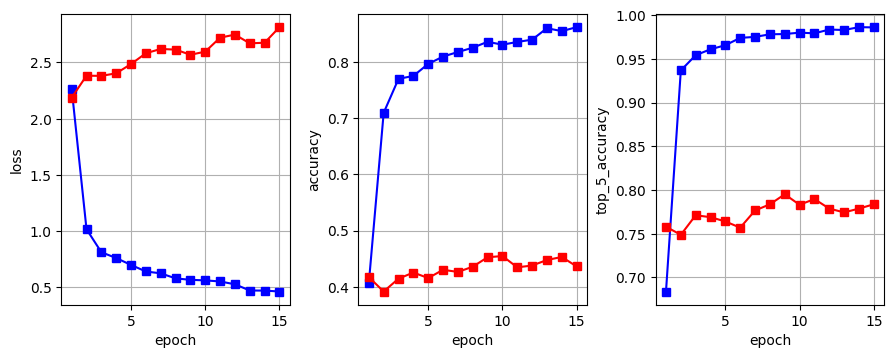

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3.5))
fig.tight_layout(); plt.subplots_adjust(wspace=0.3)
xx = np.arange(1, len(history.history['loss'])+1)
ax = axes[0]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('loss')
ax.plot(xx, history.history['loss'], color='b', marker='s')
ax.plot(xx, history.history['val_loss'], color='r', marker='s')
ax = axes[1]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('accuracy')
ax.plot(xx, history.history['accuracy'], color='b', marker='s')
ax.plot(xx, history.history['val_accuracy'], color='r', marker='s');
ax = axes[2]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('top_5_accuracy')
ax.plot(xx, history.history['top_5_accuracy'], color='b', marker='s')
ax.plot(xx, history.history['val_top_5_accuracy'], color='r', marker='s');

In [ ]:
score = model.evaluate(ds_test)
print(f'Test Loss: {score[0]:.4f}')
print(f'Test Accuracy: {score[1]:.4f}')
print(f'Test Top-5 Accuracy: {score[2]:.4f}')

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4361 - loss: 2.8312 - top_5_accuracy: 0.7790
Test Loss: 2.8685
Test Accuracy: 0.4291
Test Top-5 Accuracy: 0.7634


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_true = []
y_pred = []

for images, labels in ds_test:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
class_accuracy = cm.diagonal() / cm.sum(axis=1)
for idx, accuracy in enumerate(class_accuracy):
    print(f"Class {class_names[idx]}: {accuracy * 100:.2f}% accuracy")

print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━

Results after applying data augmentation:

* Test Loss: 2.8685
* Test Accuracy: 42.91%
* Test Top-5 Accuracy: 76.34%

For this advanced model the Per-Class Performance should also be inspected to analyze what the model manages to learn and were it is still struggling:

* High-performing classes include breeds like Egyptian Mau (93.33%), samoyed (72.92%), pug (72.22%), and keeshond (72.09%), where the model performs significantly better, likely due to more distinctive features.

* Low-performing classes such as american_pit_bull_terrier (0.00%), chihuahua (5.66%), and english_setter (12.73%) indicate difficulty in distinguishing these breeds. These errors could be attributed to either subtle visual differences between similar breeds or insufficient representation of specific classes in the dataset.

* There are mixed results for some breeds, with moderate accuracy for breeds like basset_hound (36.36%), boxer (26.00%), and Maine_Coon (25.00%), suggesting that these classes present more challenges to the model in terms of feature extraction and classification.

Overall, the model tends to struggle with fine-grained classifications between visually similar breeds, but performs better on breeds with more distinguishable features.

### CNN with Data Augmentation

In this section, the same custom CNN model was tested again, but this time with the addition of data augmentation to improve generalization. The model architecture remains the same, with two Conv2D layers, BatchNormalization, and Dropout for regularization, followed by fully connected layers.

Data Augmentation was applied to introduce variability in the training set, including:

* Random horizontal flips
* Random rotations (up to 30%)
* Random zooms (up to 30%)
* Random contrast adjustments (up to 20%)

The goal was to enhance the model's ability to handle variations in the dataset while improving generalization and reducing overfitting.

In [ ]:
class MyHyperModel(keras_tuner.HyperModel):

    def build(self, hp):
        factor = hp.Float('factor', min_value=0.1, max_value=0.5, step=0.1)
        patience = hp.Int('patience', min_value=2, max_value=10, step=2)
        l2_reg = hp.Float("l2_reg", min_value=1e-5, max_value=1e-2, sampling="log")
        model = keras.Sequential()
        model.add(keras.Input(shape=(64, 64, 3)))
        model.add(layers.RandomFlip("horizontal"))
        model.add(layers.RandomRotation(0.3))
        model.add(layers.RandomZoom(0.3))
        model.add(layers.RandomContrast(0.2))

        num_filters = hp.Int('num_filters', min_value=16, max_value=64, step=16)
        model.add(keras.layers.Conv2D(num_filters, kernel_size=(3, 3), activation='relu',
                  kernel_initializer=keras.initializers.HeUniform(),
                  kernel_regularizer=keras.regularizers.l2(l2_reg)))
        model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(keras.layers.Conv2D(num_filters * 2, kernel_size=(3, 3), activation='relu',
                  kernel_initializer=keras.initializers.HeUniform(),
                  kernel_regularizer=keras.regularizers.l2(l2_reg)))
        model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.BatchNormalization())

        model.add(keras.layers.Flatten())
        units = hp.Int('units', min_value=400, max_value=800, step=100)
        model.add(keras.layers.Dense(units=units, activation='relu',
                  kernel_initializer=keras.initializers.HeUniform()))
        model.add(layers.Dropout(rate=hp.Float('dropout_rate', 0.1, 0.3, step=0.1)))

        model.add(keras.layers.Dense(num_classes, activation='softmax',
                        kernel_initializer=keras.initializers.HeUniform()))

        learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='log')
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

        reduce_lr = keras.callbacks.ReduceLROnPlateau(
          monitor='val_accuracy',
          factor=factor,
          patience=patience,
          min_delta=1e-4,
          min_lr=1e-6)

        batch_size = hp.Int('batch_size', min_value=16, max_value=64, step=16)
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy',
                    SparseTopKCategoricalAccuracy(k=5, name='top_5_accuracy')]
        )
        return model

    def fit(self, hp, model, x, y=None, validation_data=None, **kwargs):
        factor = hp.Float('factor', min_value=0.1, max_value=0.5, step=0.1)
        patience = hp.Int('patience', min_value=2, max_value=10, step=2)

        reduce_cb = keras.callbacks.ReduceLROnPlateau(
            monitor='val_accuracy',
            factor=factor,
            patience=patience,
            min_delta=1e-4,
            min_lr=1e-6)

        early_cb = keras.callbacks.EarlyStopping(
          monitor='val_accuracy',
          patience=5,
          restore_best_weights=True)

        batch_size = hp.Int('batch_size', min_value=16, max_value=64, step=16)
        kwargs['callbacks'].extend([reduce_cb, early_cb])
        return model.fit(
            x, y,
            batch_size=batch_size,
            validation_data=validation_data,
            **kwargs
        )

In [ ]:
tuner = keras_tuner.BayesianOptimization(
    MyHyperModel(),
    objective='val_accuracy',
    max_trials=15,
    executions_per_trial=1,
    overwrite=True,
    directory='/tmp',
    project_name='oxford_pets_cnn'
)

In [ ]:
tuner.search(ds_train, validation_data=ds_val, epochs=10)

Trial 15 Complete [00h 00m 48s]
val_accuracy: 0.15040871500968933

Best val_accuracy So Far: 0.15640327334403992
Total elapsed time: 00h 09m 25s


In [ ]:
tuner.results_summary(num_trials=4)

Results summary
Results in /tmp/oxford_pets_cnn
Showing 4 best trials
Objective(name="val_accuracy", direction="max")

Trial 05 summary
Hyperparameters:
factor: 0.30000000000000004
patience: 6
l2_reg: 0.00010043716382835129
num_filters: 32
units: 800
dropout_rate: 0.1
learning_rate: 0.0004687978980564898
batch_size: 16
Score: 0.15640327334403992

Trial 03 summary
Hyperparameters:
factor: 0.5
patience: 8
l2_reg: 0.001448509053588252
num_filters: 48
units: 600
dropout_rate: 0.2
learning_rate: 0.0002082550710767042
batch_size: 48
Score: 0.15367847681045532

Trial 08 summary
Hyperparameters:
factor: 0.30000000000000004
patience: 2
l2_reg: 0.008638087527161876
num_filters: 48
units: 400
dropout_rate: 0.1
learning_rate: 0.00022790183460427854
batch_size: 16
Score: 0.15149863064289093

Trial 14 summary
Hyperparameters:
factor: 0.30000000000000004
patience: 6
l2_reg: 0.00012859725366202066
num_filters: 64
units: 800
dropout_rate: 0.1
learning_rate: 9.337117342558133e-05
batch_size: 16
Score: 0

In [ ]:
num_models = 10
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=num_models)
best_models = tuner.get_best_models(num_models=num_models)
for m in range(num_models):
  values = best_hyperparameters[m].values
  score = best_models[m].evaluate(ds_test, verbose=0)
  print(f'Model {m}: Hyperparameters: {values!s} Loss: {score[0]:.4} Accuracy: {score[1]:.2%}') #Top-5 Accuracy: {score[2]:.2%}

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model 0: Hyperparameters: {'factor': 0.30000000000000004, 'patience': 6, 'l2_reg': 0.00010043716382835129, 'num_filters': 32, 'units': 800, 'dropout_rate': 0.1, 'learning_rate': 0.0004687978980564898, 'batch_size': 16} Loss: 3.205 Accuracy: 14.78%
Model 1: Hyperparameters: {'factor': 0.5, 'patience': 8, 'l2_reg': 0.001448509053588252, 'num_filters': 48, 'units': 600, 'dropout_rate': 0.2, 'learning_rate': 0.0002082550710767042, 'batch_size': 48} Loss: 3.705 Accuracy: 13.58%
Model 2: Hyperparameters: {'factor': 0.30000000000000004, 'patience': 2, 'l2_reg': 0.008638087527161876, 'num_filters': 48, 'units': 400, 'dropout_rate': 0.1, 'learning_rate': 0.00022790183460427854, 'batch_size': 16} Loss: 4.677 Accuracy: 15.59%
Model 3: Hyperparameters: {'factor': 0.30000000000000004, 'patience': 6, 'l2_reg': 0.00012859725366202066, 'num_filters': 64, 'units': 800, 'dropout_rate': 0.1, 'learning_rate': 9.337117342558133e-05, 'batch_size': 16} Loss: 3.527 Accuracy: 13.74%
Model 4: Hyperparameters: {

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
cnn_model_params = tuner.get_best_hyperparameters(num_trials=1)[0] #saving for later

test_loss, test_accuracy, test_top5accuracy = best_model.evaluate(ds_test)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4%}')

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1541 - loss: 3.2069 - top_5_accuracy: 0.4561
Test Loss: 3.2052
Test Accuracy: 14.7764%


In [ ]:
model = MyHyperModel()
model = model.build(tuner.get_best_hyperparameters(1)[0])
history = model.fit(ds_train, validation_data=ds_val, epochs=20, verbose=0)

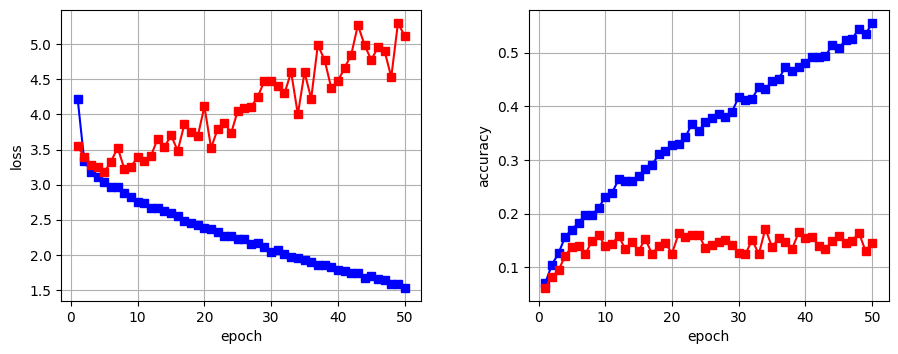

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3.5))
fig.tight_layout(); plt.subplots_adjust(wspace=0.3)
xx = np.arange(1, len(history.history['loss'])+1)
ax = axes[0]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('loss')
ax.plot(xx, history.history['loss'], color='b', marker='s')
ax.plot(xx, history.history['val_loss'], color='r', marker='s')
ax = axes[1]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('accuracy')
ax.plot(xx, history.history['accuracy'], color='b', marker='s')
ax.plot(xx, history.history['val_accuracy'], color='r', marker='s');
ax = axes[2]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('top_5_accuracy')
ax.plot(xx, history.history['top_5_accuracy'], color='b', marker='s')
ax.plot(xx, history.history['val_top_5_accuracy'], color='r', marker='s');

In [ ]:
test_loss, test_accuracy,test_top5_accuracy = model.evaluate(ds_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Top-5 Accuracy: {test_top5_accuracy:.4f}")

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.1640 - loss: 5.1056 - top_5_accuracy: 0.4715
Test Loss: 5.0411
Test Accuracy: 0.1603
Test Top-5 Accuracy: 0.4656


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_true = []
y_pred = []

for images, labels in ds_test:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
class_accuracy = cm.diagonal() / cm.sum(axis=1)
for idx, accuracy in enumerate(class_accuracy):
    print(f"Class {class_names[idx]}: {accuracy * 100:.2f}% accuracy")

print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

CNN Model with Data Augmentation:

* Test Loss: 5.0411
* Test Accuracy: 16.03%
* Test Top-5 Accuracy: 46.56%

This indicates that the model is not complex enough to effectively learn from the dataset, and with the introduction of Data Augmentation, it struggles even more. The added variability from augmentation seems to increase the model's difficulty in capturing meaningful patterns, leading to worse performance compared to the version without augmentation.

## 8.Additional model - SOTA

In this additional section, I tested a model that is known to perform well on the Oxford-IIIT Pet dataset: ResNet50. The model (https://github.com/javiergarciamolina/oxford-pets/blob/main/oxford_pets.ipynb) was adjusted to fit the setup. Here's a summary of the approach:

1. Dataset and Preprocessing: The Oxford-IIIT Pet dataset was loaded using TensorFlow Datasets and split into training, validation, and test sets.
Data augmentation was applied to the training set, including random flips, rotations, zooms, and resizing to 224x224, to improve the model's generalization.
All images were preprocessed using ResNet50's preprocessing function.

2. Model Architecture:

  * The ResNet50 model, pretrained on ImageNet, was used as the base model without the top classification layer.
  * The base model was frozen, meaning its weights were not updated during training.
  * A custom classification head was added on top of ResNet50, consisting of:
    - GlobalAveragePooling2D to reduce the feature map dimensions.
    - BatchNormalization to stabilize the training.
    - Dropout (0.5) to prevent overfitting.
    - A final Dense layer with softmax activation for classifying the pet breeds.
3. Training Setup: The model was compiled with the SGD optimizer (learning rate = 0.001) and trained for 15 epochs.

 * Callbacks included:
    - ModelCheckpoint to save the best model based on validation accuracy.
    - LearningRateScheduler to reduce the learning rate after 10 epochs to help the model converge.

In [ ]:
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.models import load_model
import tensorflow_datasets as tfds

(ds_train, ds_val, ds_test), info = tfds.load(
    'oxford_iiit_pet',
    split=['train', 'test[50%:]', 'test[:50%]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.Resizing(224, 224)
])

def preprocess(img, label):
    img = tf.image.resize(img, (224, 224))
    img = tf.keras.applications.resnet50.preprocess_input(img)
    return img, label

def augment(img, label):
    img = data_augmentation(img)
    return img, label

ds_train = ds_train.map(preprocess).map(augment).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
ds_val = ds_val.map(preprocess).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False
inputs = tf.keras.Input(shape=(224, 224, 3))

x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(info.features['label'].num_classes, activation='softmax')(x)

model = Model(inputs, outputs)
opt = SGD(learning_rate=0.001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy',
SparseTopKCategoricalAccuracy(k=5, name='top_5_accuracy')])

model.summary()
checkpoint = ModelCheckpoint('/content/drive/MyDrive/colab/dog_breed/ResNet50V2_regularized_finetuned.keras',
                             save_best_only=True, monitor='val_accuracy')

def scheduler(epoch, lr):
    if epoch > 10:
        return lr * 0.1
    return lr

lr_scheduler = LearningRateScheduler(scheduler)


history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=15,
    callbacks=[checkpoint, lr_scheduler],
    verbose=1
)

model = load_model('/content/drive/MyDrive/colab/dog_breed/ResNet50V2_regularized_finetuned.keras')

loss, accuracy, top5 = model.evaluate(ds_test)
print(f"Test Loss: {loss:.2f}")
print(f"Test accuracy: {accuracy:.2f}")
print(f"Test top-5 accuracy: {top5:.2f}")


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_27 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_9           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 37)                  │          75,813 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,671,717 (90.30 MB)

 Trainable params: 79,909 (312.14 KB)

 Non-trainable params: 23,591,808 (90.00 MB)

Epoch 1/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 66s 498ms/step - accuracy: 0.0336 - loss: 5.2032 - top_5_accuracy: 0.1503 - val_accuracy: 0.0714 - val_loss: 3.6254 - val_top_5_accuracy: 0.3014 - learning_rate: 0.0010
Epoch 2/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.0545 - loss: 4.5844 - top_5_accuracy: 0.2264 - val_accuracy: 0.1706 - val_loss: 3.1028 - val_top_5_accuracy: 0.4828 - learning_rate: 0.0010
Epoch 3/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 53s 458ms/step - accuracy: 0.1026 - loss: 4.0517 - top_5_accuracy: 0.3208 - val_accuracy: 0.2708 - val_loss: 2.6477 - val_top_5_accuracy: 0.6272 - learning_rate: 0.0010
Epoch 4/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 52s 452ms/step - accuracy: 0.1673 - loss: 3.5610 - top_5_accuracy: 0.4402 - val_accuracy: 0.3559 - val_loss: 2.2662 - val_top_5_accuracy: 0.7286 - learning_rate: 0.0010
Epoch 5/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 52s 453ms/step - accuracy: 0.1920 - loss: 3.2449 - top_5_accuracy: 0.5238 - val_accuracy: 0.4371 - val_loss: 1.9616 - val_to

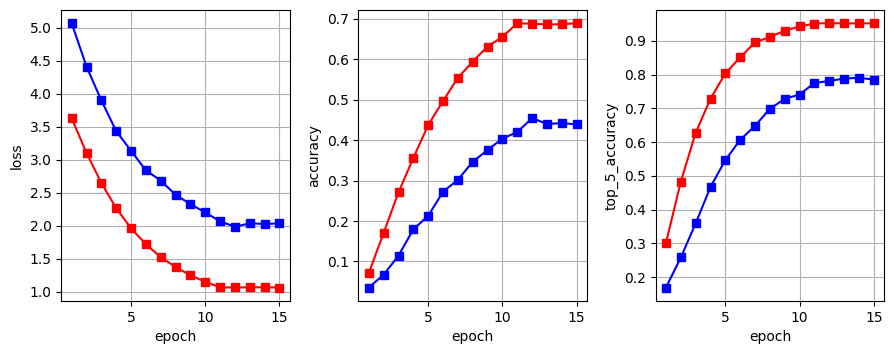

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3.5))
fig.tight_layout(); plt.subplots_adjust(wspace=0.3)
xx = np.arange(1, len(history.history['loss'])+1)
ax = axes[0]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('loss')
ax.plot(xx, history.history['loss'], color='b', marker='s')
ax.plot(xx, history.history['val_loss'], color='r', marker='s')
ax = axes[1]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('accuracy')
ax.plot(xx, history.history['accuracy'], color='b', marker='s')
ax.plot(xx, history.history['val_accuracy'], color='r', marker='s');
ax = axes[2]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('top_5_accuracy')
ax.plot(xx, history.history['top_5_accuracy'], color='b', marker='s')
ax.plot(xx, history.history['val_top_5_accuracy'], color='r', marker='s');

Results:

* Test Accuracy: 65%
* Test Top-5 Accuracy: 94%

These results show a significant improvement over previous models. The 65% test accuracy indicates that the ResNet50 model was able to correctly classify a majority of the images. The 94% top-5 accuracy demonstrates the model’s strong performance, with the correct breed being among the top 5 predictions in almost all cases. This confirms the effectiveness of using a pretrained model like ResNet50 for complex image classification tasks, especially when combined with data augmentation and fine-tuning.

### Fine Tuning

Since the model before was frozen, the last approach is to finetune the mode. After the previous ResNet50 model, the following changes were made:

* Initial Training: The ResNet50 base was frozen, and a custom classification head was trained for 15 epochs, with data augmentation applied to the training set.

* Fine-Tuning: The last 30 layers of the ResNet50 model were unfrozen, allowing them to be trainable, and fine-tuning was conducted for an additional 10 epochs with a reduced learning rate (1e-5).

This approach aimed to refine the model's performance by leveraging the power of pretrained features while fine-tuning the deeper layers for task-specific improvements.

In [ ]:
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False
inputs = tf.keras.Input(shape=(224, 224, 3))

x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(info.features['label'].num_classes, activation='softmax')(x)

model = Model(inputs, outputs)
opt = SGD(learning_rate=0.001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy',
          SparseTopKCategoricalAccuracy(k=5, name='top_5_accuracy')])

model.summary()

checkpoint = ModelCheckpoint('/content/drive/MyDrive/colab/dog_breed/ResNet50V2_regularized_finetuned.keras',
                             save_best_only=True, monitor='val_accuracy')

def scheduler(epoch, lr):
    if epoch > 10:
        return lr * 0.1
    return lr

lr_scheduler = LearningRateScheduler(scheduler)

history = model.fit(
    ds_train,
    validation_data=ds_test,
    epochs=15,
    callbacks=[checkpoint, lr_scheduler],
    verbose=1
)

#Finetuning
for layer in base_model.layers[-30:]:
    layer.trainable = True

fine_tune_learning_rate = 1e-5
model.compile(optimizer=SGD(learning_rate=fine_tune_learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', SparseTopKCategoricalAccuracy(k=5, name='top_5_accuracy')])

fine_tune_epochs = 10
history_fine = model.fit(
    ds_train,
    validation_data=ds_test,
    epochs=fine_tune_epochs,
    callbacks=[checkpoint, lr_scheduler],
    verbose=1
)

model = load_model('/content/drive/MyDrive/colab/dog_breed/ResNet50V2_regularized_finetuned.keras')


loss, accuracy, top5 = model.evaluate(ds_test)
print(f"Test accuracy: {accuracy:.2f}")
print(f"Test top-5 accuracy: {top5:.2f}")

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_30 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_10          │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 37)                  │          75,813 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,671,717 (90.30 MB)

 Trainable params: 79,909 (312.14 KB)

 Non-trainable params: 23,591,808 (90.00 MB)

Epoch 1/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 68s 515ms/step - accuracy: 0.0404 - loss: 5.0515 - top_5_accuracy: 0.1720 - val_accuracy: 0.1000 - val_loss: 3.4724 - val_top_5_accuracy: 0.3437 - learning_rate: 0.0010
Epoch 2/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 54s 473ms/step - accuracy: 0.0779 - loss: 4.4273 - top_5_accuracy: 0.2732 - val_accuracy: 0.1968 - val_loss: 2.9864 - val_top_5_accuracy: 0.5091 - learning_rate: 0.0010
Epoch 3/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 54s 469ms/step - accuracy: 0.1271 - loss: 3.9264 - top_5_accuracy: 0.3659 - val_accuracy: 0.2884 - val_loss: 2.5659 - val_top_5_accuracy: 0.6468 - learning_rate: 0.0010
Epoch 4/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 54s 468ms/step - accuracy: 0.1626 - loss: 3.4597 - top_5_accuracy: 0.4520 - val_accuracy: 0.3704 - val_loss: 2.2005 - val_top_5_accuracy: 0.7520 - learning_rate: 0.0010
Epoch 5/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 54s 471ms/step - accuracy: 0.2166 - loss: 3.1189 - top_5_accuracy: 0.5380 - val_accuracy: 0.4440 - val_loss: 1.9214 - val_to

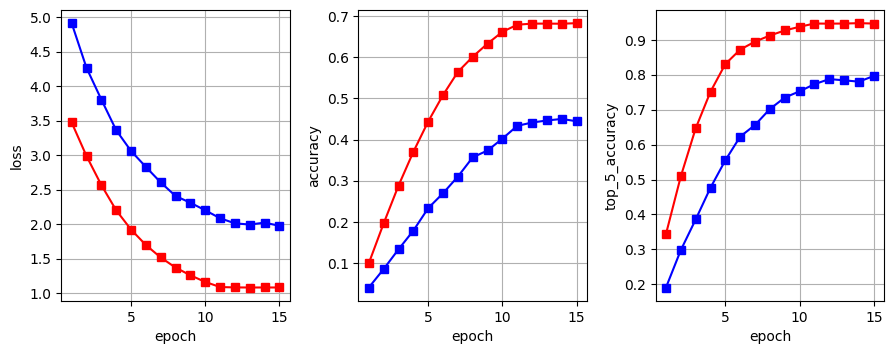

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3.5))
fig.tight_layout(); plt.subplots_adjust(wspace=0.3)
xx = np.arange(1, len(history.history['loss'])+1)
ax = axes[0]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('loss')
ax.plot(xx, history.history['loss'], color='b', marker='s')
ax.plot(xx, history.history['val_loss'], color='r', marker='s')
ax = axes[1]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('accuracy')
ax.plot(xx, history.history['accuracy'], color='b', marker='s')
ax.plot(xx, history.history['val_accuracy'], color='r', marker='s');
ax = axes[2]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('top_5_accuracy')
ax.plot(xx, history.history['top_5_accuracy'], color='b', marker='s')
ax.plot(xx, history.history['val_top_5_accuracy'], color='r', marker='s');

Results after fine-tuning:

- **Test Accuracy**: 68%
- **Test Top-5 Accuracy**: 95%

These results show a further improvement compared to the previous model, with a higher test accuracy and top-5 accuracy. Fine-tuning the deeper layers of ResNet50 after the initial training allowed the model to better adapt to the dataset, leading to improved performance on the test set.

## Conclusion
In this project, various approaches were explored to classify images from the Oxford-IIIT Pet dataset. Starting with basic models such as simple MLPS, CNNs and progressively moving to more advanced techniques like Transfer Learning using MobileNetV2 and ResNet50, significant improvements were made. The introduction of data augmentation and fine-tuning strategies helped enhance the model's ability to generalize and improve accuracy, particularly with pretrained models. The best performance was achieved through ResNet50 fine-tuning, resulting in a 68% test accuracy and a 95% top-5 accuracy.

Further steps could include using more advanced models like EfficientNet or incorporate Ensemble Methods. Of course further hyperparameter optimisation would be necessary with more resources.